In [1]:
import sys
sys.path.append('/home/campbell/yulee/DAMM/new/code/pro')

from funcs6 import *
import joblib

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
plt.rcParams['figure.figsize'] = [20, 10]

In [2]:
cohort = 'eddy'
ss = 10

In [3]:
tr_exp = sc.read_h5ad('/home/campbell/yulee/DAMM/new/data/{}/{}k/tr_exp.h5ad'.format(cohort, ss))
te_exp = sc.read_h5ad('/home/campbell/yulee/DAMM/new/data/{}/{}k/te_exp.h5ad'.format(cohort, ss))
pretty_printing = np.hstack([tr_exp.var_names, 'size'])

In [4]:
#nc = len(analysisProteins)
batchSize = 128
learnRate = 1e-3
nm = 'student'
rr = 1
rv = 10
r = 0

In [5]:
## compute training and test set
#trY, trS = prepData(tr_exp, 1, analysisProteins) ## inc cell sizes
#teY, teS = prepData(te_exp, 1, analysisProteins) ## inc cell sizes

trY, trS = prepData(tr_exp, 1) ## inc cell sizes
teY, teS = prepData(te_exp, 1) ## inc cell sizes

trFY, trFS, trFL = simulate_data(trY, trS, 1) ## relax rule
teFY, teFS, teFL = simulate_data(teY, teS, 1) ## relax rule

trMat = np.hstack((trY, trS.reshape(-1,1)))
teMat = np.hstack((teY, teS.reshape(-1,1)))
trFMat = np.hstack((trFY, trFS.reshape(-1,1)))
teFMat = np.hstack((teFY, teFS.reshape(-1,1)))
df = ConcatDataset(trY, trS, trFY, trFS, trFL)

# PhenoGraph

In [6]:
#import phenograph
import scanpy.external as sce
pheno_labels, _, _ = sce.tl.phenograph(trMat)
tr_exp.obs['pheno_label'] = pheno_labels.astype(str)

## set number of clusters
nc = len(np.unique(pheno_labels))
pheno_centers = np.zeros((nc, trMat.shape[1]))
for k in range(nc):
    pheno_centers[k,:] = trMat[pheno_labels==k].mean(0)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 3.935465097427368 seconds
Jaccard graph constructed in 1.2968263626098633 seconds
Wrote graph to binary file in 0.32903552055358887 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.809112
After 11 runs, maximum modularity is Q = 0.810775
Louvain completed 31 runs in 10.63929557800293 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 16.498565435409546 seconds


In [7]:
tr_exp.obs['pheno_label'].value_counts()

0     1272
1     1194
2     1151
3     1007
4      790
5      740
6      644
7      618
8      546
9      496
10     457
11     330
12     314
13     171
14     158
15     112
Name: pheno_label, dtype: int64

In [8]:
nc

16

# FlowSOM

In [9]:
from flowsom import flowsom as flowsom
from sklearn.cluster import AgglomerativeClustering

oPath = '/home/campbell/yulee/DAMM/new/res/{}/{}k/ex1/'.format(cohort, ss)
fs_fn = oPath + 'fsom1t_nc{}_{}_rv{}_rr{}_{}.csv'.format(nc, nm, rv, rr, r)
pd.DataFrame(np.array(trMat), columns = pretty_printing).to_csv(fs_fn)
fsom = flowsom(fs_fn, if_fcs=False, if_drop=True, drop_col=['Unnamed: 0'])

#fn = oPath + 'fsom1.csv'
#fsom = flowsom(fn, if_fcs=False, if_drop=True, drop_col=['Unnamed: 0'])

fsom.som_mapping(50, # x_n: e.g. 100, the dimension of expected map
       50, # y_n: e.g. 100, the dimension of expected map
       fsom.df.shape[1],
       1, # sigma: e.g 1, the standard deviation of initialized weights
       0.5, # lr: e.g 0.5, learning rate
       1000, # batch_size: 1000, iteration times
       tf_str=None, # string, e.g. hlog', None, etc - the transform algorithm
       if_fcs=False # bool, whethe the imput file is fcs file. If not, it should be a csv file
       # seed = 10, for reproducing
      )

start = nc; fsom_nc = 0
while fsom_nc < nc:
    print(nc, start, fsom_nc)
    fsom.meta_clustering(AgglomerativeClustering, min_n=start, max_n=start, verbose=True, iter_n=10) # train the meta clustering for cluster in range(40,45)  

    fsom.labeling()
    #fsom.bestk # the best number of clusters within the range of (min_n, max_n)
    fsom_class = np.unique(fsom.df['category'])
    fsom_nc = len(fsom_class)
    start += 1
    
fsom_labels = np.array(fsom.df['category'])
fsom_sorted_by_count = pd.Series(fsom_labels).value_counts().index

fsom_label = np.zeros(trMat.shape[0], dtype=int)
for i, val in enumerate(fsom_sorted_by_count):
    fsom_label[fsom_labels == val] = i
tr_exp.obs['fsom_label'] = fsom_label.astype(str)

'''
tr_exp.obs['fsom_label'] = 0
for i, val in enumerate(fsom_sorted_by_count):
    idx = fsom_labels == val
    tr_exp.obs['fsom_label'].iloc[idx] = i
    #print(len(tr_exp.obs['fsom_label'].iloc[idx]))
tr_exp.obs['fsom_label'] = tr_exp.obs['fsom_label'].astype(str)
'''

#fsom.meta_clustering(AgglomerativeClustering, min_n=start, max_n=start, verbose=True, iter_n=5)
fsom_centers = np.zeros((max(fsom_class)+1, fsom.df.shape[1]))
for row in range(max(fsom_class)+1):
    fsom_centers[row,:] = fsom.df[fsom_labels==row].mean(0)

fsom_centers = fsom_centers[fsom_sorted_by_count]
fs_centers = fsom_centers[:,:-1]
#pd.DataFrame(fs_centers, columns = fsom.df.columns[:-1])
#pd.DataFrame(out_center, columns = fsom.df.columns[:-1]).to_csv(oName)
#fsom.df['category'].to_csv(oPath + 'fsom{}_label_nc{}.csv'.format(cs, fsom_nc))

Training...
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 8.572777363649442

...ready!
16 16 0
0 samples done...
16 17 12
0 samples done...
16 18 13
0 samples done...
16 19 14
0 samples done...
16 20 15
0 samples done...


In [10]:
tr_exp.obs['fsom_label'].value_counts()

0     1458
1     1289
2     1251
3     1206
4      869
5      822
6      656
7      628
8      614
9      426
10     225
11     180
12     178
13     104
14      54
15      40
Name: fsom_label, dtype: int64

# Random Forest

In [11]:
## run random forest
rf = RandomForestClassifier()
rf.fit(trFMat, trFL)

## save classifiers
#joblib.dump(rf, orf_classifier)

## compute random forest performance of simulated data (confusion matrix)
rf_p_fake_singlet = rf.predict_proba(teFMat)[:,1]
rtn, rfp, rfn, rtp, racc, rf1, rsens, rspec = evalM(rf_p_fake_singlet, teFL)

In [12]:
rf1

0.8239951278928137

# Kmeans Initalization

In [13]:
## damm initialization
Theta0, okms_labels, okms_centers = kmeans_init1(trMat, 1, nc) ## inc cell sizes

## save kmeans results as damm initialization
#torch.save(Theta, output_theta0)

## save kmeans labels (in anndata object)
okms_sorted_by_count = pd.Series(okms_labels).value_counts().index

kms_label = np.zeros(trMat.shape[0], dtype=int)
for i, val in enumerate(okms_sorted_by_count):
    kms_label[okms_labels == val] = i
tr_exp.obs['kms_label'] = kms_label.astype(str)

'''
tr_exp.obs['kms_label'] = 0
for i, val in enumerate(okms_sorted_by_count):
    idx = okms_labels == val
    tr_exp.obs['kms_label'].iloc[idx] = str(i)
    #print(len(tr_exp.obs['fsom_label'].iloc[idx]))
tr_exp.obs['kms_label'] = tr_exp.obs['kms_label'].astype(str)
'''

## save kmeans centers
okms_centers = okms_centers[okms_sorted_by_count]
#pd.DataFrame(okms_centers, columns = pretty_printing).to_csv(ookms_centers)

In [14]:
tr_exp.obs['kms_label'].value_counts()

0     1239
1     1227
2     1084
3      968
4      815
5      777
6      762
7      605
8      413
9      405
10     370
11     365
12     326
13     287
14     259
15      98
Name: kms_label, dtype: int64

## RF on Kmeans

In [15]:
#singlet_indices = np.where(rf.predict_proba(okms_centers)[:,0] <= 0.5)[0]
#Theta1 = {k: v.detach()[singlet_indices].requires_grad_(True) for (k,v) in Theta0.items()}
#Theta1['is_tau'] = Theta1['is_tau'].detach()[:,np.r_[singlet_indices]].requires_grad_(True)

# DAMM

In [16]:
loss, Theta1 = trainWFD(df, rr, Theta0, batchSize, nm, learnRate, rv)

/home/campbell/yulee/DAMM/new/code/pro/funcs6.py:237: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  ccmax = torch.combinations(psi).max(1).values


## Loss Curve

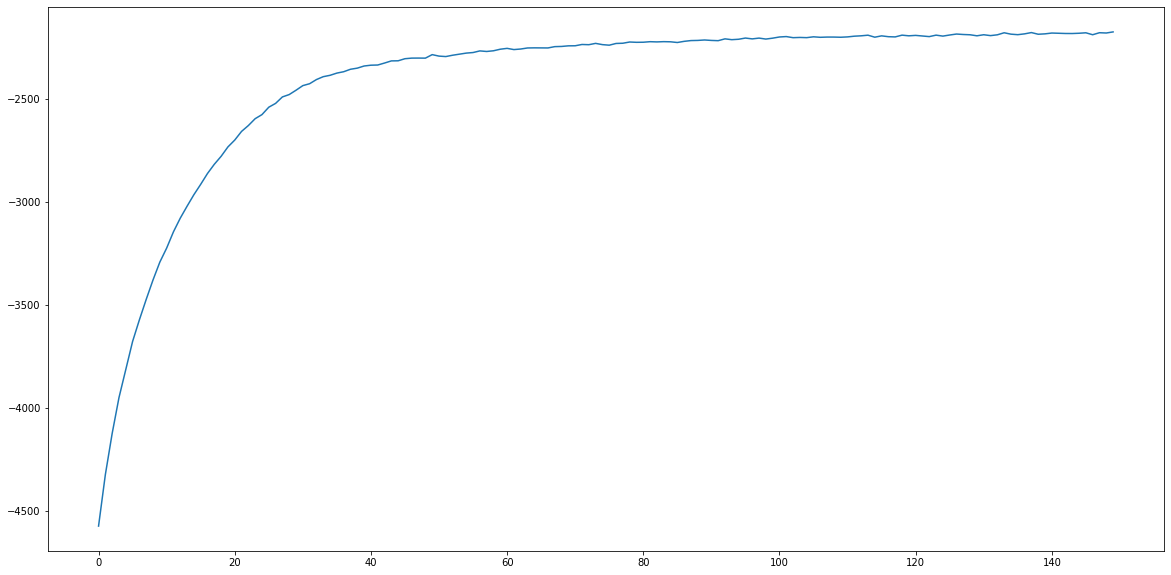

In [17]:
## total loss
plt.plot(np.array(loss)[:,0])

## Label

In [18]:
## output model parameters
#torch.save([loss, Theta], output_theta1)

## damm's doublet performance
with torch.no_grad():
    
    pred_loader = torch.utils.data.DataLoader(ConcatDataset(teFY, teFS), batch_size = 5000, shuffle = False)
    
    damm_p_fake_singlets = []
    for i, bat in enumerate(pred_loader):
        _, _, _ , damm_p_fake_singlet = compute_posteriors_nll_p_singlet(bat[0], bat[1], Theta1, nm, rr)
        damm_p_fake_singlets.append(damm_p_fake_singlet)
        
    ## compute damm performance of simulated data (confusion matrix)
    dtn, dfp, dfn, dtp, dacc, df1, dsens, dspec = evalM(torch.hstack(damm_p_fake_singlets), teFL)
    
    iter_out = [nc, nm, rv, rr, r, 
        rtn, rfp, rfn, rtp, racc, rf1, rsens, rspec,
        dtn, dfp, dfn, dtp, dacc, df1, dsens, dspec]

    ## output doublet performances
    #pd.Series(iter_out).to_csv(odoublet_performance)
    
    ## DAMM label
    damm_pred_singlet_label, damm_pred_singlet_cluster_assig_label, _ = get_assign_labels1(trY, trS, rr, Theta1, nm)    
    damm_sorted_by_count = pd.Series(damm_pred_singlet_cluster_assig_label).value_counts().index
    
    if len(damm_sorted_by_count) != nc:
        damm_sorted_by_count = np.hstack((damm_sorted_by_count, np.setdiff1d(range(nc), damm_sorted_by_count)))
        
    ## save damm labels
    damm_labels = np.zeros(trMat.shape[0], dtype=int) + 50
    damm_labels[damm_pred_singlet_label == 0] = damm_pred_singlet_cluster_assig_label
    
    damm_label = np.zeros(trMat.shape[0], dtype=int) + 50
    for i, val in enumerate(damm_sorted_by_count):
        damm_label[damm_labels == val] = i
    damm_label = damm_label.astype(str)
    damm_label[damm_label == '50'] = 'doublets'
    tr_exp.obs['damm_label'] = damm_label

    #tr_exp.obs['damm_label'] = 50 #len(np.unique(damm_pred_singlet_cluster_assig_label))
    #tr_exp.obs.iloc[np.where(damm_pred_singlet_label == 0)[0],-1] = damm_pred_singlet_cluster_assig_label
    
    ## save damm centers
    damm_centers = np.array(torch.hstack([Theta1['log_mu'], Theta1['log_psi'].reshape(-1,1)]).exp())
    damm_centers = damm_centers[damm_sorted_by_count]
    #pd.DataFrame(damm_centers, columns = pretty_printing).to_csv(odamm_centers)

    ## output phenograph/kmeans/damm labels
    #tr_exp.obs.iloc[:,5:].to_csv(olabels)

In [19]:
tr_exp.obs['damm_label'].value_counts()

0           2909
1           1515
2           1464
3           1395
doublets    1394
4            521
5            402
6            205
7             88
8             57
9             27
10             8
11             8
12             5
13             2
Name: damm_label, dtype: int64

## Doublet Probability

In [20]:
with torch.no_grad():
    _, _, _, p_singlet = compute_posteriors_nll_p_singlet(trY, trS, Theta1, nm, rr)
tr_exp.obs['prob_doublet'] = 1 - p_singlet

/home/campbell/yulee/.local/share/virtualenvs/yulee-9RaDnU2W/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'pheno_label' as categorical
/home/campbell/yulee/.local/share/virtualenvs/yulee-9RaDnU2W/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'fsom_label' as categorical
/home/campbell/yulee/.local/share/virtualenvs/yulee-9RaDnU2W/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` pa

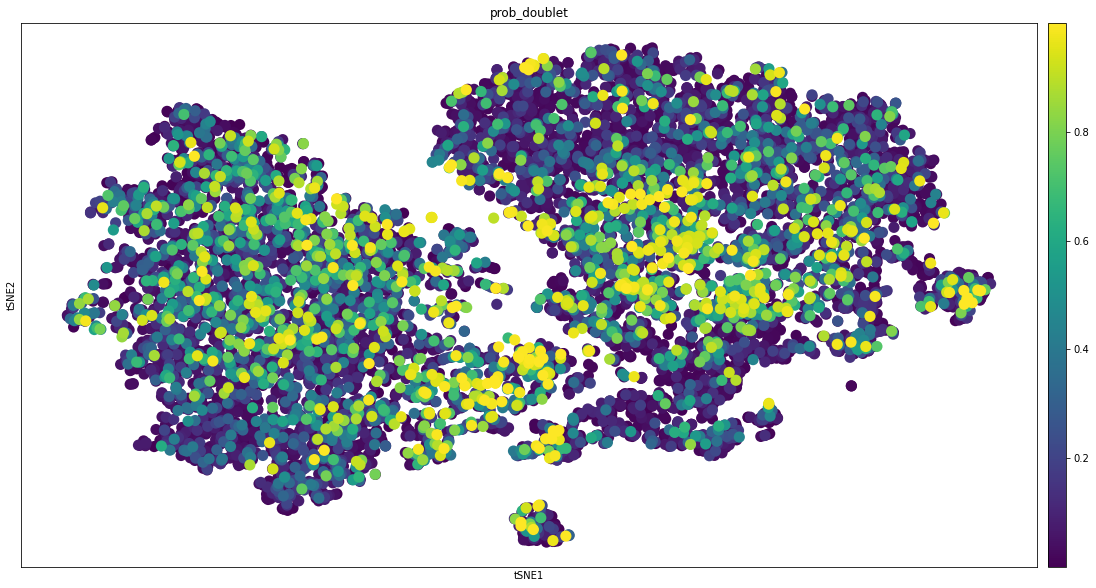

In [21]:
sc.tl.tsne(tr_exp)
sc.pl.tsne(tr_exp, color="prob_doublet", size=500)

In [22]:
## compute neighbors for tsne
#sc.pp.scale(tr_exp, max_value=3)
#sc.tl.pca(tr_exp)
#sc.pp.neighbors(tr_exp, use_rep="X_pca")
#sc.tl.tsne(tr_exp)
#sc.pl.tsne(tr_exp, color="prob_doublet", size=500)

In [23]:
sum(p_singlet.detach() > 0.5)

tensor(8606)

In [24]:
pd.DataFrame(pheno_centers, columns = pretty_printing)

,Stroma,PDL1,CD68,MHCII,CD28,RFP,ICOS,YAP,CD19,HA,...,CD49b,CCR7,CD11b,S100A8-9,DNA1,DNA3,CD45,PNAd,CD31,size
0,6.270601,2.868851,0.689276,0.225665,0.819679,5.107012,0.282738,0.760172,0.347457,0.579178,...,1.643259,4.377983,1.953791,0.142780,12.202023,20.876061,0.754264,0.346373,1.593135,22.229560
1,3.852701,1.033796,1.011031,0.091795,0.445861,1.461182,0.104615,0.590402,0.249281,0.134771,...,0.593941,2.699594,2.414587,0.127042,10.094878,17.389741,0.715907,0.251663,1.790136,30.556951
2,3.891572,1.154929,0.930279,0.094834,0.409906,1.647019,0.117922,0.595576,0.410079,0.167141,...,0.638491,2.447574,2.257677,0.114965,10.953037,18.623846,0.718357,0.303141,1.713110,16.235447
3,11.020925,4.685228,0.995947,0.263826,0.812063,5.473442,0.316467,0.822834,0.403477,0.542268,...,1.662798,4.526368,2.128425,0.147705,10.622574,18.128310,0.692311,0.366375,1.547072,36.397219
4,3.764747,1.013293,0.620730,0.088023,0.470610,1.427893,0.096850,0.423406,0.230045,0.127403,...,0.456773,2.909968,2.123197,0.110559,10.853565,18.726972,0.771480,0.250676,1.688197,41.541772
5,8.810914,4.133086,1.098988,0.249281,0.848710,5.473340,0.311979,0.779034,0.379159,0.547895,...,1.650569,4.545539,2.159720,0.154719,10.608386,18.206055,0.721154,0.354785,1.556388,50.409459
6,3.720498,1.370919,0.828687,0.111851,0.327836,2.451530,0.158916,0.827677,1.505578,0.316907,...,0.982052,1.345406,2.121232,0.111833,12.681750,21.682007,0.666564,0.508252,1.692668,26.875776
7,6.145426,2.558485,0.748261,0.259918,0.931838,5.848838,0.324130,0.748879,0.493763,0.671579,...,1.792681,4.577793,2.024479,0.155401,15.560188,26.490457,0.860265,0.470317,1.743242,42.768608
8,3.940020,1.089226,0.887600,0.092673,0.425712,1.562923,0.109096,0.673841,0.442073,0.135124,...,0.674031,2.366373,2.830896,0.133493,10.481371,17.901653,0.716802,0.267976,1.895681,65.750916
9,3.682890,1.062080,0.994457,0.094109,0.455471,1.465403,0.102817,0.464525,0.388708,0.143959,...,0.491407,2.526607,2.342049,0.116630,10.986350,18.891694,0.761317,0.248487,1.697889,51.727823


In [25]:
pd.DataFrame(fs_centers, columns = fsom.df.columns[:-1])

,Stroma,PDL1,CD68,MHCII,CD28,RFP,ICOS,YAP,CD19,HA,...,CD49b,CCR7,CD11b,S100A8-9,DNA1,DNA3,CD45,PNAd,CD31,size
0,3.744483,1.181303,0.638219,0.101297,0.489079,1.925164,0.126458,0.506322,0.273968,0.201333,...,0.650953,2.845029,1.888985,0.106201,11.055388,18.898916,0.736643,0.269636,1.650803,27.714678
1,3.918013,1.089093,0.818370,0.095154,0.469490,1.677808,0.110663,0.581506,0.316996,0.159240,...,0.629310,2.695183,2.473611,0.127906,10.638196,18.283037,0.743703,0.328122,1.759608,44.767261
2,6.368599,2.974423,0.718219,0.238798,0.850002,5.219365,0.294549,0.706352,0.400646,0.582503,...,1.647705,4.372104,1.985501,0.146687,12.587353,21.482868,0.767933,0.377645,1.590953,36.629097
3,3.878027,1.171355,1.048984,0.104393,0.343825,1.983734,0.134225,0.793162,1.083857,0.223684,...,0.898152,1.594841,2.665364,0.131180,11.396344,19.476961,0.670997,0.467350,1.838677,33.514925
4,3.880535,1.171286,0.910744,0.092786,0.359554,1.735131,0.123800,0.733569,0.674943,0.193655,...,0.752121,2.107492,2.293896,0.117882,11.156463,19.152238,0.669934,0.432801,1.754062,15.008055
5,6.674143,2.955627,0.697747,0.234445,0.847848,5.276343,0.284174,0.755524,0.361316,0.598702,...,1.690681,4.608810,2.006195,0.145899,12.797444,21.839121,0.780713,0.361384,1.616593,19.857664
6,6.938721,2.891825,1.125228,0.202249,0.661988,4.342786,0.247589,0.905023,0.781277,0.444605,...,1.468906,3.201713,2.609755,0.155312,12.060250,20.584246,0.716661,0.728672,1.787224,76.196646
7,4.009468,1.217491,0.828695,0.098308,0.436034,1.748772,0.118318,0.671153,0.494055,0.160528,...,0.712627,2.391192,2.603310,0.125886,10.579624,18.095664,0.720695,0.385082,1.841080,60.866242
8,8.907366,4.433141,1.067757,0.256809,0.848943,5.639688,0.326130,0.837294,0.419342,0.546967,...,1.693555,4.619528,2.181293,0.152727,10.613189,18.187952,0.730863,0.487245,1.614270,52.412052
9,17.604649,5.995376,1.467580,0.310060,0.811461,5.993081,0.356757,1.018228,0.491411,0.552029,...,1.758624,4.676403,2.434387,0.165788,9.752635,16.703586,0.644386,0.570024,1.608005,35.638498


In [26]:
pd.DataFrame(okms_centers, columns = pretty_printing)

,Stroma,PDL1,CD68,MHCII,CD28,RFP,ICOS,YAP,CD19,HA,...,CD49b,CCR7,CD11b,S100A8-9,DNA1,DNA3,CD45,PNAd,CD31,size
0,3.936624,1.147930,0.815413,0.094044,0.432278,1.728307,0.115765,0.623989,0.303411,0.161196,...,0.666212,2.525186,2.207748,0.115924,10.451133,17.891870,0.703758,0.357247,1.740939,25.073446
1,3.762557,1.024599,0.800586,0.089317,0.437526,1.552401,0.107562,0.555687,0.352795,0.146840,...,0.590830,2.573342,2.303181,0.119463,10.577209,18.202059,0.732215,0.327886,1.749520,35.832111
2,7.309946,3.451610,0.822031,0.233609,0.809554,5.147744,0.290081,0.768927,0.405260,0.557428,...,1.654284,4.348711,1.972028,0.139001,11.456473,19.604364,0.730601,0.447007,1.576085,32.973247
3,3.844948,1.079726,0.841140,0.094075,0.454111,1.607697,0.107956,0.619898,0.337401,0.148327,...,0.625114,2.572490,2.573533,0.128923,10.447784,17.945710,0.731070,0.350008,1.798193,47.414256
4,4.508237,1.497738,1.191011,0.116363,0.426662,2.175024,0.147165,0.791008,0.489235,0.223482,...,0.878912,2.436685,2.488564,0.131433,10.597807,18.064844,0.687354,0.523823,1.764882,12.776687
5,6.176375,2.897265,0.607528,0.231887,0.856500,5.217276,0.285588,0.738894,0.356433,0.599721,...,1.663719,4.552807,1.924484,0.143431,12.787643,21.872221,0.772877,0.353565,1.608810,19.463320
6,6.937540,3.501153,0.919064,0.242167,0.862864,5.447748,0.307832,0.752780,0.448522,0.561452,...,1.666095,4.329127,2.075108,0.149284,11.527819,19.662098,0.745251,0.421562,1.587109,47.851706
7,4.172382,1.310127,0.837985,0.105069,0.423709,2.030917,0.132732,0.773418,0.675812,0.187361,...,0.836391,2.204441,2.673502,0.130805,10.596436,18.126150,0.712870,0.559825,1.895920,61.705785
8,8.559164,4.254343,1.033166,0.268862,0.902489,5.771435,0.315656,0.818959,0.440412,0.592832,...,1.742777,4.668366,2.120139,0.155592,12.178084,20.827076,0.765816,0.529703,1.661558,65.249395
9,3.650561,1.290980,0.881404,0.112978,0.277021,2.433585,0.168719,0.920894,1.853653,0.338302,...,0.998339,1.027596,2.275740,0.114544,13.771162,23.492719,0.679305,0.717759,1.750688,25.232099


In [27]:
#pd.DataFrame(okms_centers[singlet_indices], columns = pretty_printing)

In [28]:
pd.DataFrame(damm_centers, columns = pretty_printing)

,Stroma,PDL1,CD68,MHCII,CD28,RFP,ICOS,YAP,CD19,HA,...,CD49b,CCR7,CD11b,S100A8-9,DNA1,DNA3,CD45,PNAd,CD31,size
0,3.534167,0.795962,0.248484,0.076510,0.468471,1.349586,0.090192,0.334474,0.139997,0.114854,...,0.324281,2.782014,1.715486,0.097454,10.692982,18.181471,0.751095,0.222827,1.604066,27.561496
1,6.738878,2.779783,0.406052,0.239578,0.905394,5.767713,0.316959,0.693744,0.269468,0.643300,...,1.782260,4.994622,1.894712,0.141838,12.457034,21.122664,0.809490,0.317191,1.665490,30.311799
2,5.406186,2.175050,0.381554,0.192565,0.676799,4.256595,0.250050,0.600751,0.317760,0.509659,...,1.384328,3.219993,1.395382,0.112618,11.274969,18.917047,0.630998,0.285831,1.304140,31.587026
3,2.921511,0.534653,0.266697,0.053123,0.201094,1.161081,0.083258,0.467536,0.854018,0.131985,...,0.499523,0.923950,1.885890,0.097773,11.160852,18.843920,0.606221,0.245341,1.697353,29.672416
4,14.499765,5.301491,0.910678,0.319674,0.816061,7.435160,0.396145,1.031415,0.488751,0.651148,...,2.041578,4.554409,2.529055,0.188802,9.473216,16.248858,0.684732,0.381487,1.857949,23.994656
5,5.276410,1.839613,0.436713,0.195743,0.447483,6.151797,0.318517,1.054058,2.022196,0.627533,...,1.683196,1.162968,1.942781,0.125117,11.634668,20.218286,0.617671,0.425006,1.505183,31.142412
6,2.911356,2.012911,0.298444,0.170960,0.176187,3.123778,0.179923,0.934651,3.182759,0.609966,...,1.568474,0.624861,1.258032,0.059835,11.641998,19.736611,0.543174,0.281418,1.418475,35.815707
7,8.347634,6.640223,1.126747,0.379946,0.931137,6.961992,0.358515,0.987299,0.347852,0.475341,...,1.786343,4.849827,2.994627,0.168824,11.822829,20.299991,0.693281,0.321073,1.667944,57.581117
8,9.169939,3.560657,0.476675,0.259419,0.878835,5.002913,0.262731,0.649401,0.375137,0.481245,...,1.421388,3.822880,2.038700,0.178757,11.157700,20.694144,0.667493,0.309449,1.400415,63.815174
9,3.133856,0.836947,0.445642,0.098669,0.307680,1.473332,0.110285,0.610709,0.363043,0.106024,...,0.429038,1.515544,1.821690,0.092731,9.631043,17.568007,0.596334,0.245324,1.508522,31.592955


# Expression Heatmap (scaled)

In [29]:
scaler = MinMaxScaler()
#s2 = scaler.fit(np.vstack([pheno_centers, fsom_centers, okms_centers, okms_centers[singlet_indices], damm_centers]))
s2 = scaler.fit(np.vstack([pheno_centers, fs_centers, okms_centers, damm_centers]))

#s2 = scaler.fit(np.vstack([pheno_centers, fs_centers, damm_centers]))

## PhenoGraph

Text(156.0, 0.5, 'Cluster')

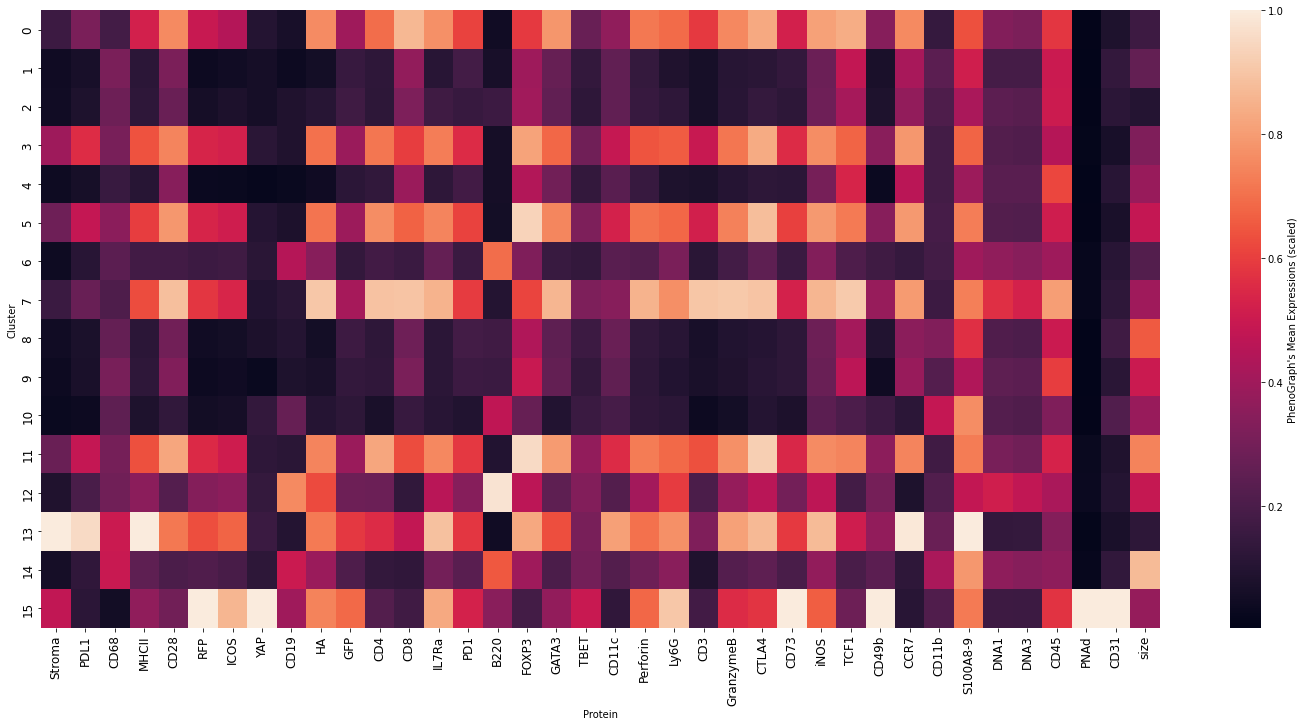

In [30]:
s3 = scaler.transform(pheno_centers)
mat = pd.DataFrame(s3, columns = pretty_printing)
ax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={'label': "PhenoGraph's Mean Expressions (scaled)"})
ax.set_xticklabels(ax.get_xticklabels(), size = 12, horizontalalignment = 'center')
ax.set_yticklabels(ax.get_yticklabels(), size = 12, verticalalignment = 'center')
ax.figure.tight_layout()
plt.xlabel("Protein")
plt.ylabel("Cluster")

### Doublet Prob

In [31]:
rf.predict_proba(pheno_centers)[:,0]

array([0.21, 0.41, 0.42, 0.44, 0.78, 0.81, 0.77, 0.53, 0.99, 0.91, 0.64,
       0.96, 0.93, 0.22, 1.  , 0.41])

## FlowSOM

Text(156.0, 0.5, 'Cluster')

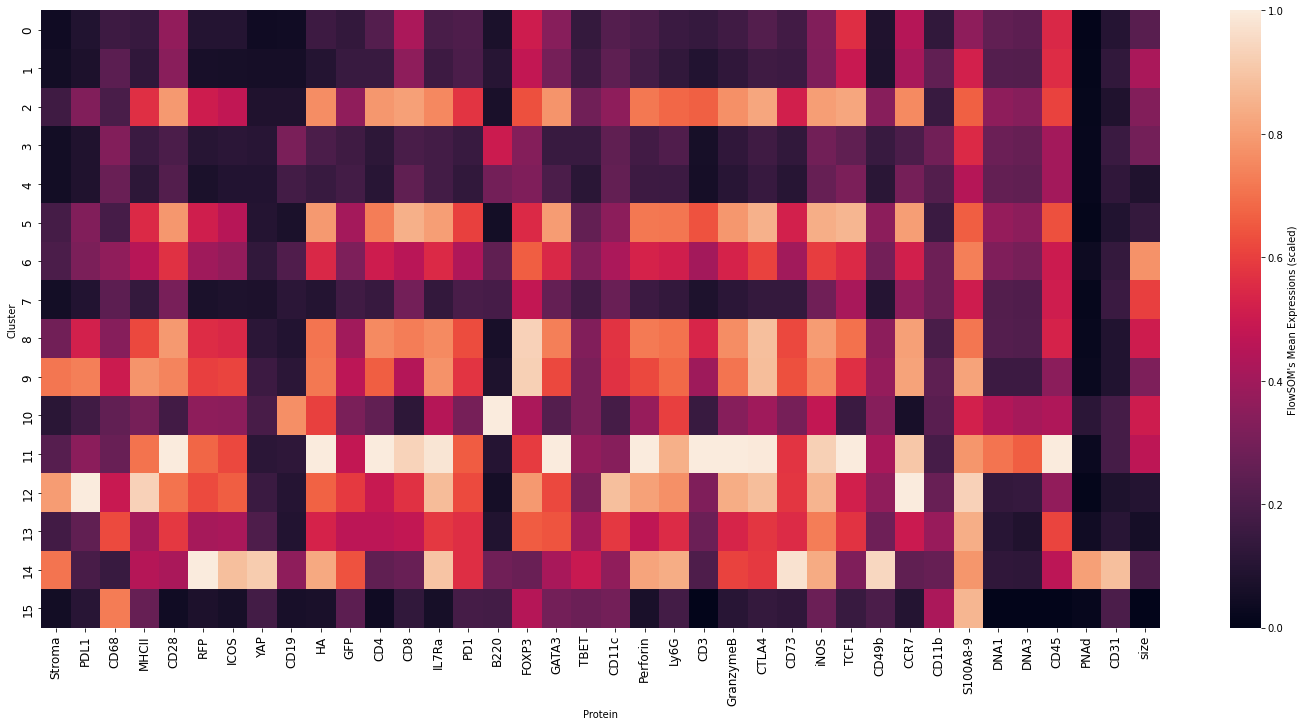

In [32]:
s3 = scaler.transform(fs_centers)
mat = pd.DataFrame(s3, columns = pretty_printing)
ax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={'label': "FlowSOM's Mean Expressions (scaled)"})
ax.set_xticklabels(ax.get_xticklabels(), size = 12, horizontalalignment = 'center')
ax.set_yticklabels(ax.get_yticklabels(), size = 12, verticalalignment = 'center')
ax.figure.tight_layout()
plt.xlabel("Protein")
plt.ylabel("Cluster")

### Doublet Prob

In [33]:
rf.predict_proba(fs_centers)[:,0]

array([0.7 , 0.88, 0.43, 0.77, 0.44, 0.19, 1.  , 0.98, 0.82, 0.36, 0.89,
       0.4 , 0.23, 0.47, 0.34, 0.25])

## Kmeans

Text(156.0, 0.5, 'Cluster')

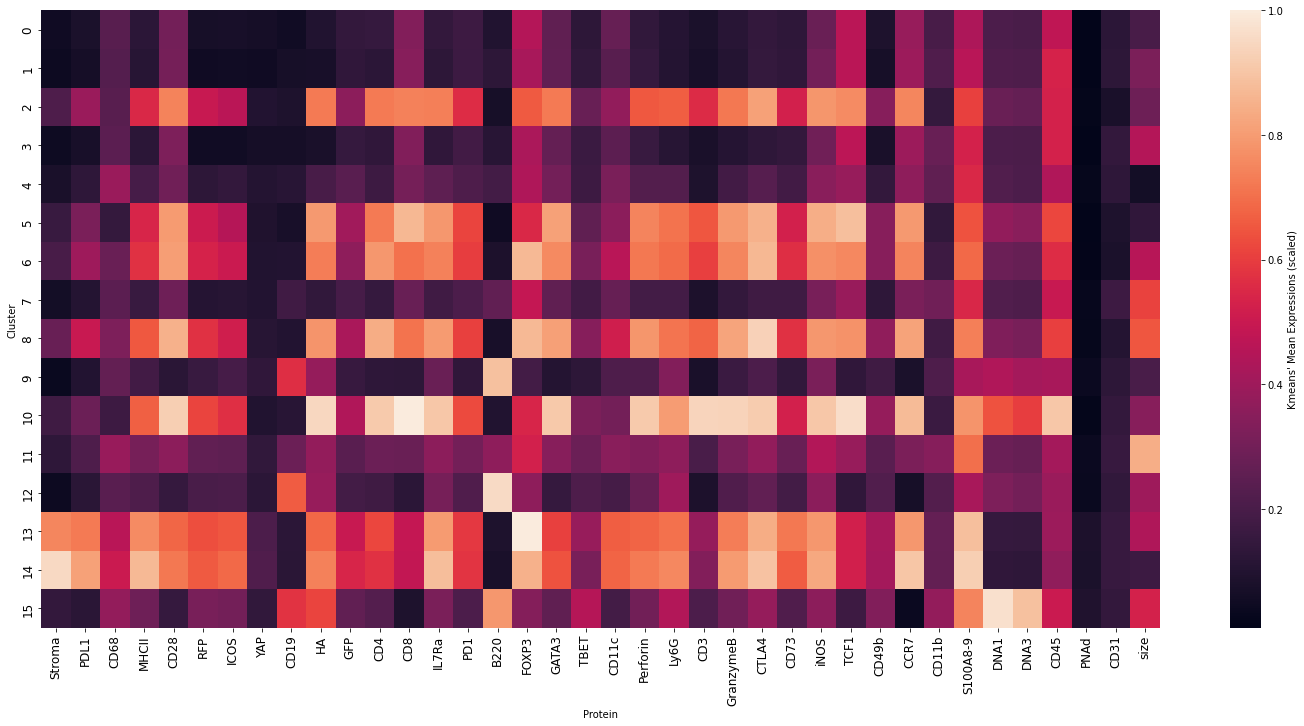

In [34]:
s3 = scaler.transform(okms_centers)
mat = pd.DataFrame(s3, columns = pretty_printing)
ax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={'label': "Kmeans' Mean Expressions (scaled)"})
ax.set_xticklabels(ax.get_xticklabels(), size = 12, horizontalalignment = 'center')
ax.set_yticklabels(ax.get_yticklabels(), size = 12, verticalalignment = 'center')
ax.figure.tight_layout()
plt.xlabel("Protein")
plt.ylabel("Cluster")

### Doublet Prob

In [35]:
rf.predict_proba(okms_centers)[:,0]

array([0.4 , 0.54, 0.34, 0.93, 0.49, 0.18, 0.78, 0.96, 0.97, 0.63, 0.34,
       1.  , 0.91, 0.72, 0.22, 0.85])

# RF on Kmeans

In [36]:
'''
s3 = scaler.transform(okms_centers[singlet_indices])
mat = pd.DataFrame(s3, columns = pretty_printing)
ax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={'label': "RF on Kmeans' Mean Expressions (scaled)"})
ax.set_xticklabels(ax.get_xticklabels(), size = 12, horizontalalignment = 'center')
ax.set_yticklabels(ax.get_yticklabels(), size = 12, verticalalignment = 'center')
ax.figure.tight_layout()
plt.xlabel("Protein")
plt.ylabel("Cluster")
'''

'\ns3 = scaler.transform(okms_centers[singlet_indices])\nmat = pd.DataFrame(s3, columns = pretty_printing)\nax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={\'label\': "RF on Kmeans\' Mean Expressions (scaled)"})\nax.set_xticklabels(ax.get_xticklabels(), size = 12, horizontalalignment = \'center\')\nax.set_yticklabels(ax.get_yticklabels(), size = 12, verticalalignment = \'center\')\nax.figure.tight_layout()\nplt.xlabel("Protein")\nplt.ylabel("Cluster")\n'

In [37]:
#rf.predict_proba(okms_centers[singlet_indices])[:,0]

## DAMM

Text(156.0, 0.5, 'Cluster')

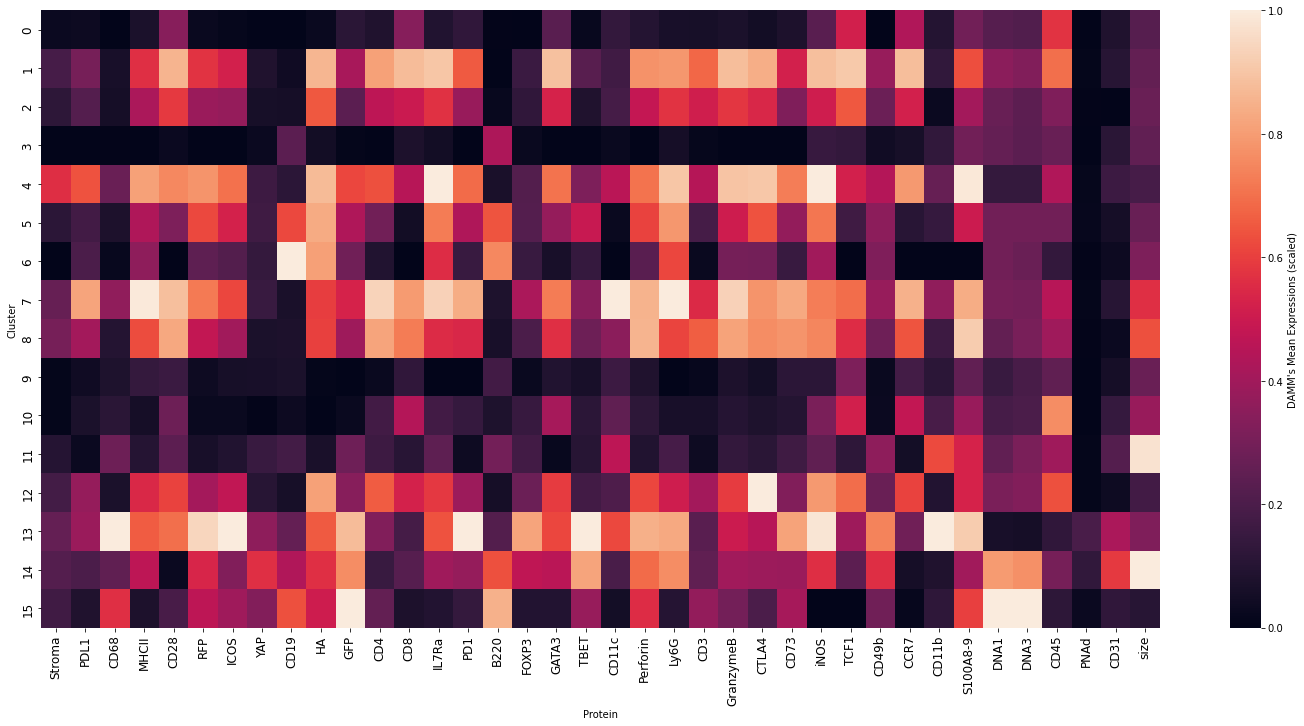

In [38]:
s3 = scaler.transform(damm_centers)
mat = pd.DataFrame(s3, columns = pretty_printing)
ax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={'label': "DAMM's Mean Expressions (scaled)"})
ax.set_xticklabels(ax.get_xticklabels(), size = 12, horizontalalignment = 'center')
ax.set_yticklabels(ax.get_yticklabels(), size = 12, verticalalignment = 'center')
ax.figure.tight_layout()
plt.xlabel("Protein")
plt.ylabel("Cluster")

### Doublet Prob

In [39]:
rf.predict_proba(damm_centers)[:,0]

array([0.3 , 0.13, 0.25, 0.31, 0.18, 0.31, 0.21, 0.7 , 0.84, 0.41, 0.72,
       0.91, 0.29, 0.48, 0.83, 0.33])

# UMAP of PhenoGraph/FlowSOM/Kmeans/DAMM clusters

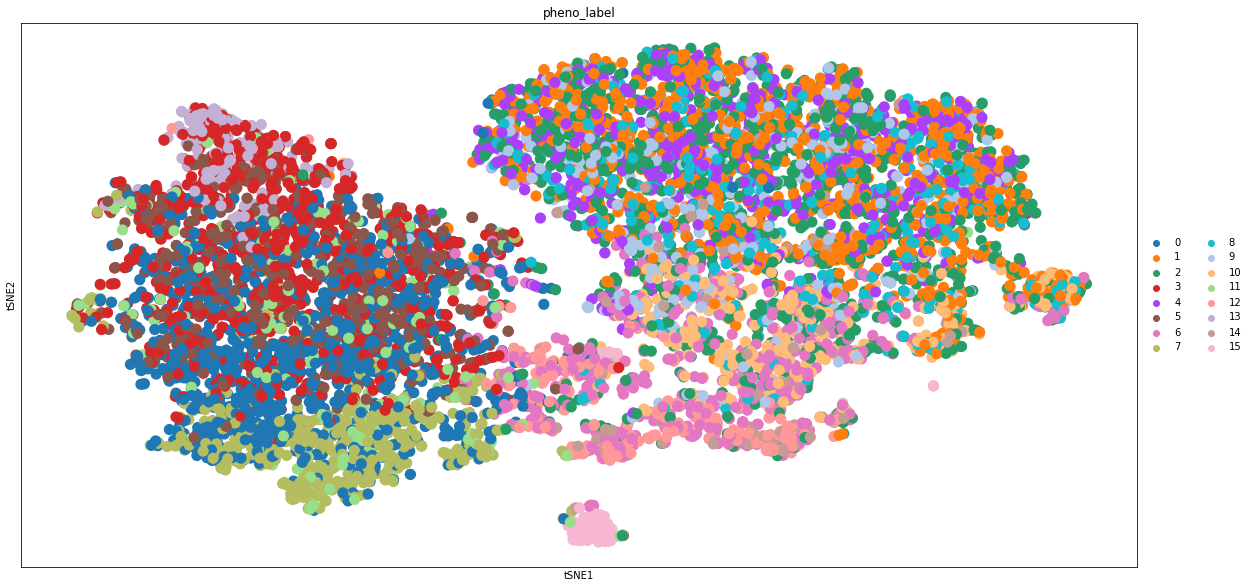

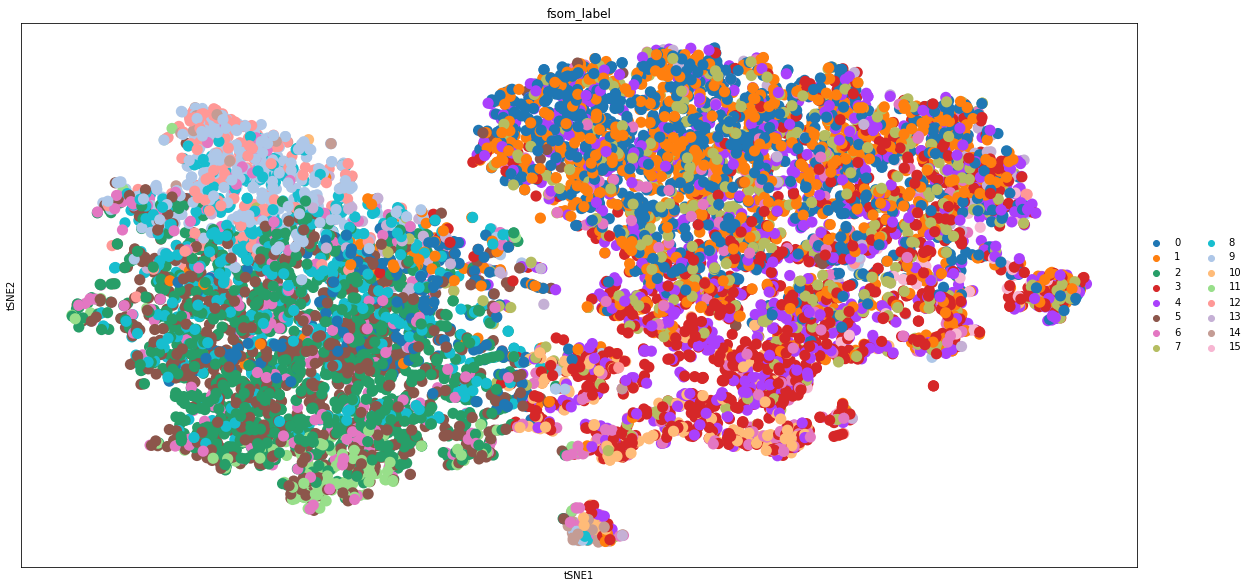

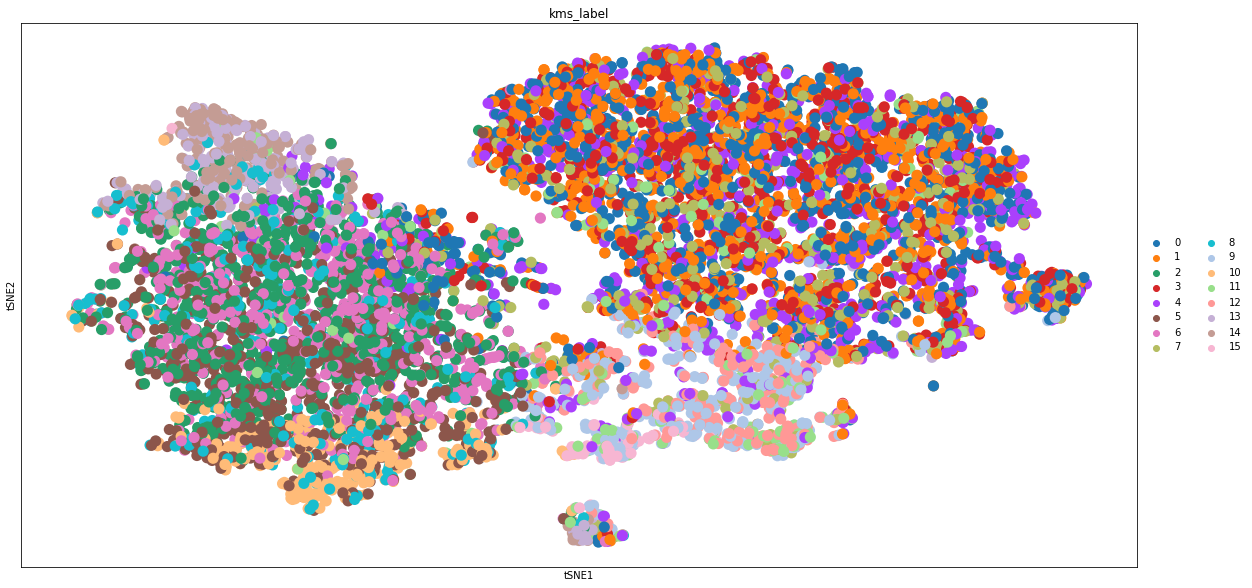

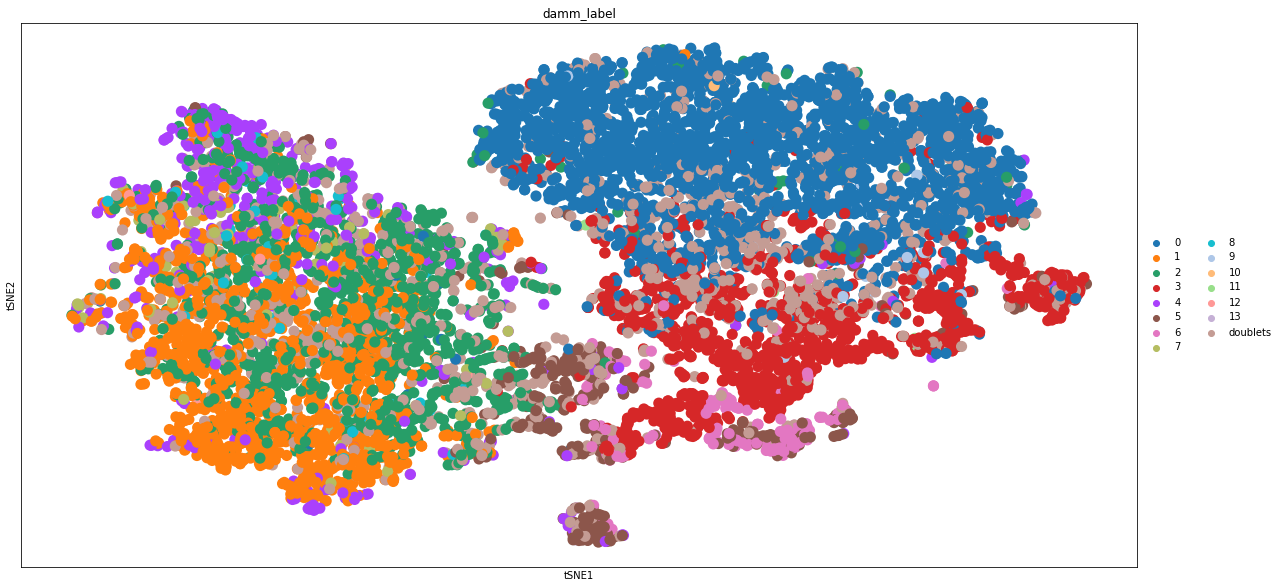

In [40]:
sc.pl.tsne(tr_exp, color = "pheno_label", size = 500)
sc.pl.tsne(tr_exp, color = "fsom_label", size = 500)
sc.pl.tsne(tr_exp, color = "kms_label", size = 500)
sc.pl.tsne(tr_exp, color = "damm_label", size = 500)

# New Correlation

In [41]:
def newMetric2(mat1, mat2, anti, pairs, thresholds, gp=1):
    out = []
    for pair in pairs:

        x_name = pair[0]; y_name = pair[1]
        #x = np.array(pheno_mat[x_name]); y = np.array(pheno_mat[y_name])
        #x = np.array(damm_mat[x_name]); y = np.array(damm_mat[y_name])
        x1 = np.array(mat1[x_name]); y1 = np.array(mat1[y_name])
        x2 = np.array(mat2[x_name]); y2 = np.array(mat2[y_name])
    
        if anti:
            ## case 1: negative
            score1 = sum((x1 < thresholds[x_name][0]) | (y1 < thresholds[y_name][0]))/len(x1)
            score2 = sum((x2 < thresholds[x_name][0]) | (y2 < thresholds[y_name][0]))/len(x2)
            out.append([x_name + '_' + y_name, score1, score2, 0])
        else:
            ## case 2: positive
            score1 = sum((x1 > thresholds[x_name][1]) | (y1 < thresholds[y_name][0]))/len(x1)
            score2 = sum((x2 > thresholds[x_name][1]) | (y2 < thresholds[y_name][0]))/len(x2)
            out.append([x_name + '_' + y_name, score1, score2, 1])
            
        print("{}_{} -- PG: {}; DAMM: {}".format(x_name, y_name, score1, score2))
        
        '''
        plt.scatter(x1, y1)
        plt.axvline(x=thresholds[x_name][0], color='r')
        plt.axvline(x=thresholds[x_name][1], color='r')    
        plt.axhline(y=thresholds[y_name][0], color='r')
        plt.axhline(y=thresholds[y_name][1], color='r')
        plt.xlabel(x_name)
        plt.ylabel(y_name)
        plt.title("PhenoGraph anti: {}".format(anti))
        plt.show()
        
        plt.scatter(x2, y2)
        plt.axvline(x=thresholds[x_name][0], color='r')
        plt.axvline(x=thresholds[x_name][1], color='r')    
        plt.axhline(y=thresholds[y_name][0], color='r')
        plt.axhline(y=thresholds[y_name][1], color='r')
        plt.xlabel(x_name)
        plt.ylabel(y_name)
        plt.title("DAMM anti: {}".format(anti))
        plt.show()
        '''
    if gp:
        out_col = ['pair', 'PhenoGraph', 'DAMM', 'type']
    else:
        out_col = ['pair', 'FlowSOM', 'DAMM', 'type']
    return pd.DataFrame(out, columns = out_col)

In [42]:
thresholds = pd.DataFrame(np.quantile(tr_exp.X, [0.25, 0.75], axis=0), columns = pretty_printing[:-1])

In [43]:
thresholds

,Stroma,PDL1,CD68,MHCII,CD28,RFP,ICOS,YAP,CD19,HA,...,TCF1,CD49b,CCR7,CD11b,S100A8-9,DNA1,DNA3,CD45,PNAd,CD31
0,3.055556,0.681653,0.200000,0.065217,0.333333,1.314815,0.083333,0.352941,0.162791,0.116667,...,4.041667,0.366667,1.673724,1.342376,0.068182,9.591837,16.535715,0.571429,0.192176,1.365308
1,6.983532,2.844888,0.823728,0.235294,0.785714,5.128412,0.296746,0.846154,0.642857,0.566121,...,8.466666,1.678571,4.300758,2.601163,0.178571,12.731708,21.722701,0.864407,0.375000,1.870968


In [44]:
if cohort == 'eddy':
    anti_pairs = [['CD3','CD19'],
              ['CD3','CD68'],
              ['CD4','CD8'],
              ['CD4','CD19'],
              ['CD4','CD68'],
              ['CD8','CD11b'],
              ['CD8','CD19'],
              ['CD8','CD68'],
              ['CD19','CD68']]
    co_pairs = [['CD3','CD4'],
            ['CD3','CD8'],
            ['CD45','CD3'],
            ['CD45','CD4'],
            ['CD45','CD8'],
            ['CD45','CD19'],
            ['CD45','CD68']]
else:
    anti_pairs = [['CD3', 'CD20'], 
              ['CD3', 'CD68'], 
              ['CD3', 'panCK'], 
              ['CD3', 'CD31'],
              ['CD20', 'CD68'], 
              ['CD20', 'panCK'], 
              ['CD20', 'CD31'], 
              ['CD45', 'panCK'], 
              ['panCK', 'Vimentin']]
    
    co_pairs = [['CD45', 'CD3'],
            ['CD45', 'CD20'],
            ['CD45', 'CD68'],
            ['panCK', 'CK5'],
            ['panCK', 'CK7'],
            ['panCK', 'CK8_18'],
            ['panCK', 'CK19']]

In [45]:
#!pip install --upgrade matplotlib>=3.3.4

In [46]:
pheno_mat = pd.DataFrame(pheno_centers, columns = pretty_printing)
damm_mat = pd.DataFrame(damm_centers, columns = pretty_printing)
anti = newMetric2(pheno_mat, damm_mat, 1, anti_pairs, thresholds, 1)
co = newMetric2(pheno_mat, damm_mat, 0, co_pairs, thresholds, 1)
df = pd.concat([anti, co])

CD3_CD19 -- PG: 0.0625; DAMM: 0.3125
CD3_CD68 -- PG: 0.0625; DAMM: 0.25
CD4_CD8 -- PG: 0.125; DAMM: 0.375
CD4_CD19 -- PG: 0.0; DAMM: 0.125
CD4_CD68 -- PG: 0.0; DAMM: 0.0625
CD8_CD11b -- PG: 0.125; DAMM: 0.375
CD8_CD19 -- PG: 0.125; DAMM: 0.4375
CD8_CD68 -- PG: 0.125; DAMM: 0.375
CD19_CD68 -- PG: 0.0; DAMM: 0.0625
CD3_CD4 -- PG: 0.1875; DAMM: 0.25
CD3_CD8 -- PG: 0.3125; DAMM: 0.5625
CD45_CD3 -- PG: 0.0625; DAMM: 0.25
CD45_CD4 -- PG: 0.0; DAMM: 0.0625
CD45_CD8 -- PG: 0.125; DAMM: 0.375
CD45_CD19 -- PG: 0.0; DAMM: 0.0625
CD45_CD68 -- PG: 0.0; DAMM: 0.0


Text(0.5, 0.98, 'eddy: Correlation Alternative')

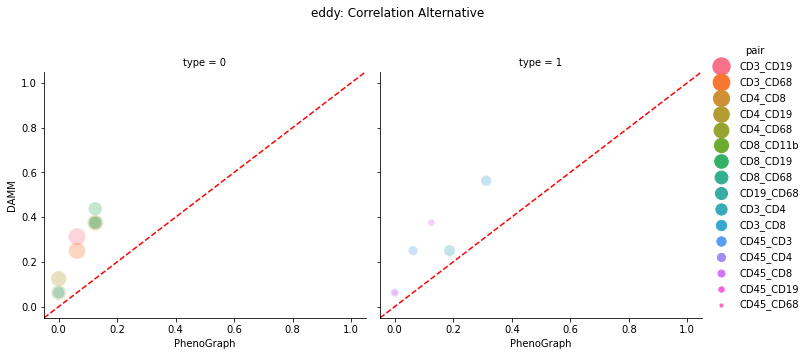

In [47]:
rel = sns.relplot(data=df, x='PhenoGraph', y='DAMM', col='type', hue='pair', size="pair", sizes=(10, 300), alpha = 0.3)
#rel = sns.relplot(data=df, x='PhenoGraph', y='DAMM', col='type', hue='pair')
for ax in rel.axes_dict.values():
    ax.axline((0, 0), (1,1), ls="--", color ='red')
#rel.data = df  # Hack needed to work around bug on v0.11, fixed in v0.12.dev
#rel.map(sns.lineplot, 'PhenoGraph', 'DAMM')
rel.fig.subplots_adjust(top=.8)
rel.fig.suptitle('{}: Correlation Alternative'.format(cohort))

In [48]:
fs_mat = pd.DataFrame(fs_centers, columns = pretty_printing)
anti = newMetric2(fs_mat, damm_mat, 1, anti_pairs, thresholds, 0)
co = newMetric2(fs_mat, damm_mat, 0, co_pairs, thresholds, 0)
df = pd.concat([anti, co])

CD3_CD19 -- PG: 0.0625; DAMM: 0.3125
CD3_CD68 -- PG: 0.0625; DAMM: 0.25
CD4_CD8 -- PG: 0.125; DAMM: 0.375
CD4_CD19 -- PG: 0.0; DAMM: 0.125
CD4_CD68 -- PG: 0.0; DAMM: 0.0625
CD8_CD11b -- PG: 0.125; DAMM: 0.375
CD8_CD19 -- PG: 0.125; DAMM: 0.4375
CD8_CD68 -- PG: 0.125; DAMM: 0.375
CD19_CD68 -- PG: 0.0; DAMM: 0.0625
CD3_CD4 -- PG: 0.25; DAMM: 0.25
CD3_CD8 -- PG: 0.375; DAMM: 0.5625
CD45_CD3 -- PG: 0.125; DAMM: 0.25
CD45_CD4 -- PG: 0.0625; DAMM: 0.0625
CD45_CD8 -- PG: 0.1875; DAMM: 0.375
CD45_CD19 -- PG: 0.0625; DAMM: 0.0625
CD45_CD68 -- PG: 0.0625; DAMM: 0.0


Text(0.5, 0.98, 'eddy: Correlation Alternative')

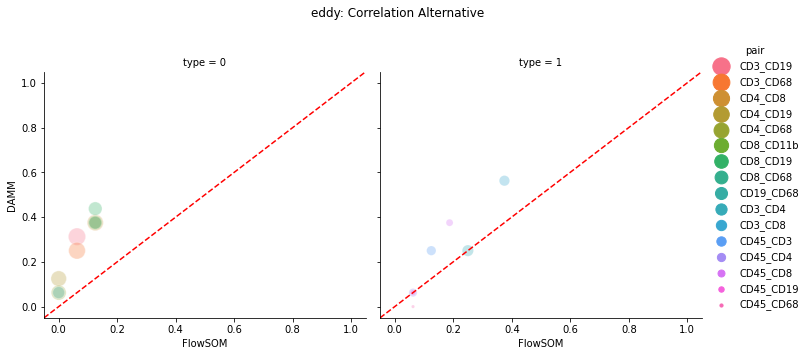

In [49]:
rel = sns.relplot(data=df, x='FlowSOM', y='DAMM', col='type', hue='pair', size="pair", sizes=(10, 300), alpha = 0.3)
#rel = sns.relplot(data=df, x='PhenoGraph', y='DAMM', col='type', hue='pair')
for ax in rel.axes_dict.values():
    ax.axline((0, 0), (1,1), ls="--", color ='red')
#rel.data = df  # Hack needed to work around bug on v0.11, fixed in v0.12.dev
#rel.map(sns.lineplot, 'PhenoGraph', 'DAMM')
rel.fig.subplots_adjust(top=.8)
rel.fig.suptitle('{}: Correlation Alternative'.format(cohort))

# ARS of PhenoGraph/FlowSOM/Kmeans/DAMM

In [50]:
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(tr_exp.obs['pheno_label'], tr_exp.obs['fsom_label'])

0.3807679292623225

In [51]:
adjusted_rand_score(tr_exp.obs['pheno_label'], tr_exp.obs['kms_label'])

0.42383630924258353

In [52]:
adjusted_rand_score(tr_exp.obs['pheno_label'], tr_exp.obs['damm_label'])

0.20027302835023195

In [53]:
adjusted_rand_score(tr_exp.obs['fsom_label'], tr_exp.obs['kms_label'])

0.4523041976962052

In [54]:
adjusted_rand_score(tr_exp.obs['fsom_label'], tr_exp.obs['damm_label'])

0.1914742327430212

In [55]:
adjusted_rand_score(tr_exp.obs['kms_label'], tr_exp.obs['damm_label'])

0.17809635787399916

# Confusion matrix of PG/FS vs DAMM clusters

In [56]:
##remove doublet cells
singlet_set = tr_exp.obs[tr_exp.obs['damm_label'] != 'doublets']

In [57]:
singlet_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8606 entries, ILNd_3535 to ILNd_16461
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   sample        8606 non-null   category
 1   id            8606 non-null   int64   
 2   x             8606 non-null   float64 
 3   y             8606 non-null   float64 
 4   area          8606 non-null   int64   
 5   area_convex   8606 non-null   int64   
 6   pheno_label   8606 non-null   category
 7   fsom_label    8606 non-null   category
 8   kms_label     8606 non-null   category
 9   damm_label    8606 non-null   category
 10  prob_doublet  8606 non-null   float64 
dtypes: category(5), float64(3), int64(3)
memory usage: 515.4+ KB


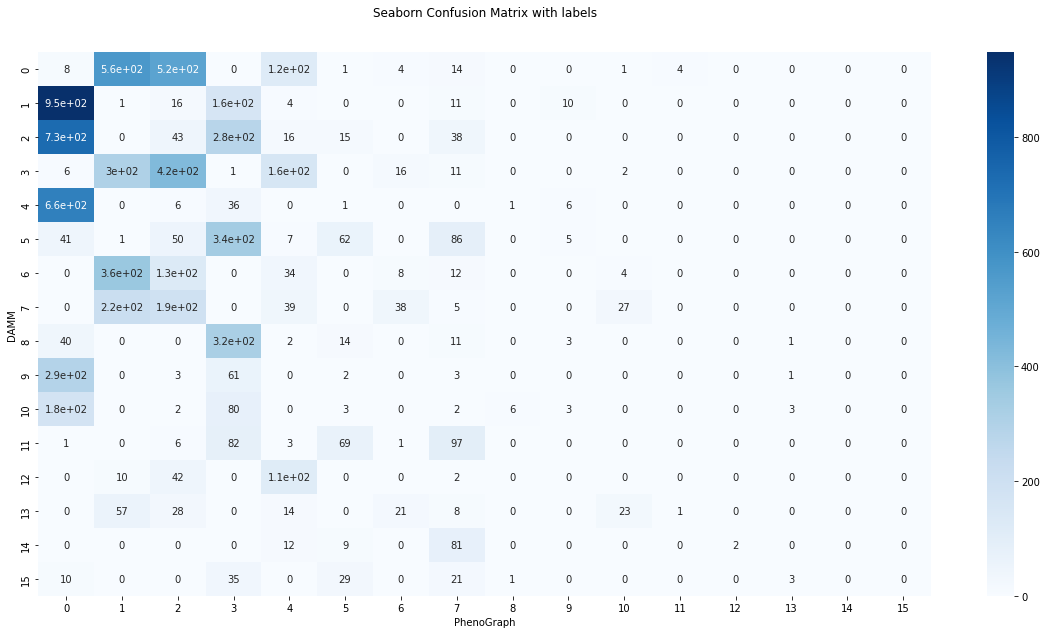

In [58]:
##use singlet cells to compute confusion matrix
cf_mat = confusion_matrix(singlet_set['pheno_label'], singlet_set['damm_label'], labels = singlet_set['pheno_label'].value_counts().index)

ax = sns.heatmap(cf_mat, annot=True, cmap='Blues');

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('PhenoGraph');
ax.set_ylabel('DAMM');

## Ticket labels - List must be in alphabetical order
#ax.xaxis.set_ticklabels(['False','True'])
#ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

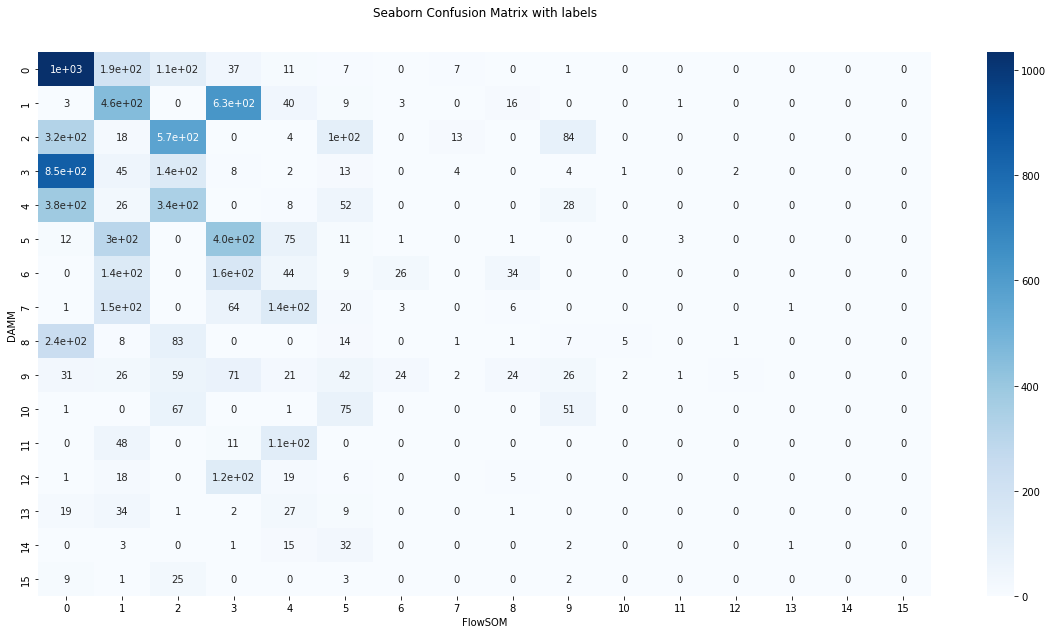

In [59]:
cf_mat = confusion_matrix(singlet_set['fsom_label'], singlet_set['damm_label'], labels = singlet_set['fsom_label'].value_counts().index)

ax = sns.heatmap(cf_mat, annot=True, cmap='Blues');

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('FlowSOM');
ax.set_ylabel('DAMM');

## Ticket labels - List must be in alphabetical order
#ax.xaxis.set_ticklabels(['False','True'])
#ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Doublet distribution

In [60]:
doublet_set = tr_exp.obs[tr_exp.obs['damm_label'] == 'doublets']

In [61]:
doublet_set['pheno_label'].value_counts()

8     270
5     222
11    178
9     136
3      88
4      82
7      67
10     64
14     59
12     55
6      53
1      43
0      33
2      31
15      8
13      5
Name: pheno_label, dtype: int64

In [62]:
doublet_set['fsom_label'].value_counts()

6     322
7     269
1     219
8     197
3      98
2      94
0      58
9      39
10     30
4      25
5      18
13     11
11      9
12      5
14      0
15      0
Name: fsom_label, dtype: int64

# Pinch Effect

In [63]:
#area of convex hull of cell / area of cell

/home/campbell/yulee/.local/share/virtualenvs/yulee-9RaDnU2W/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, "Pinch Effect:DAMM's Singlet Cells")

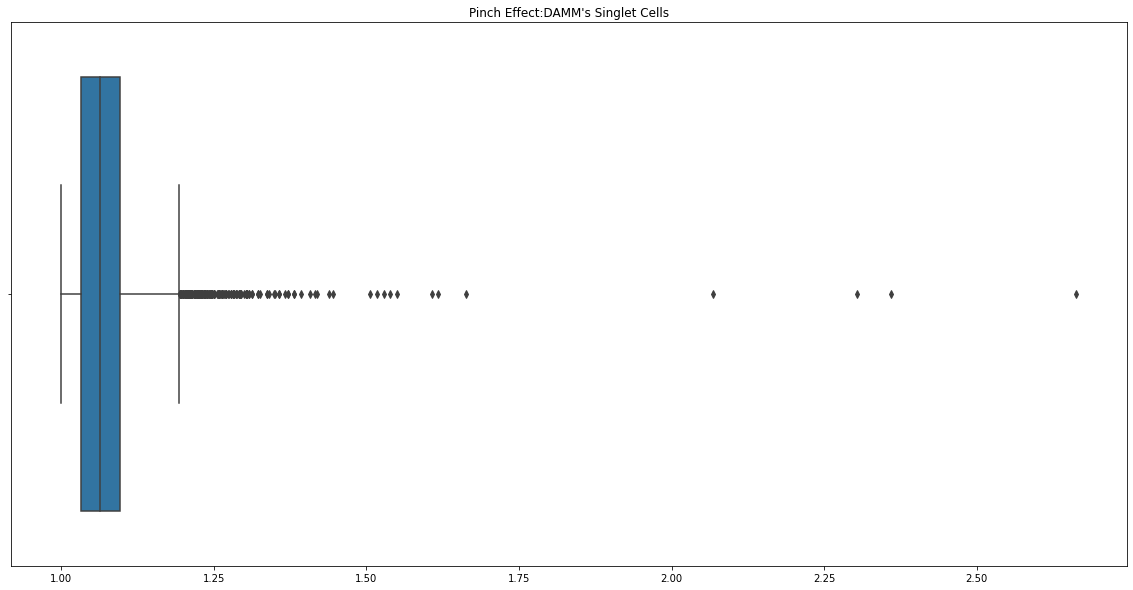

In [64]:
sns.boxplot(singlet_set['area_convex']/singlet_set['area'])
plt.title("Pinch Effect:DAMM's Singlet Cells")

/home/campbell/yulee/.local/share/virtualenvs/yulee-9RaDnU2W/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, "Pinch Effect:DAMM's Doublet Cells")

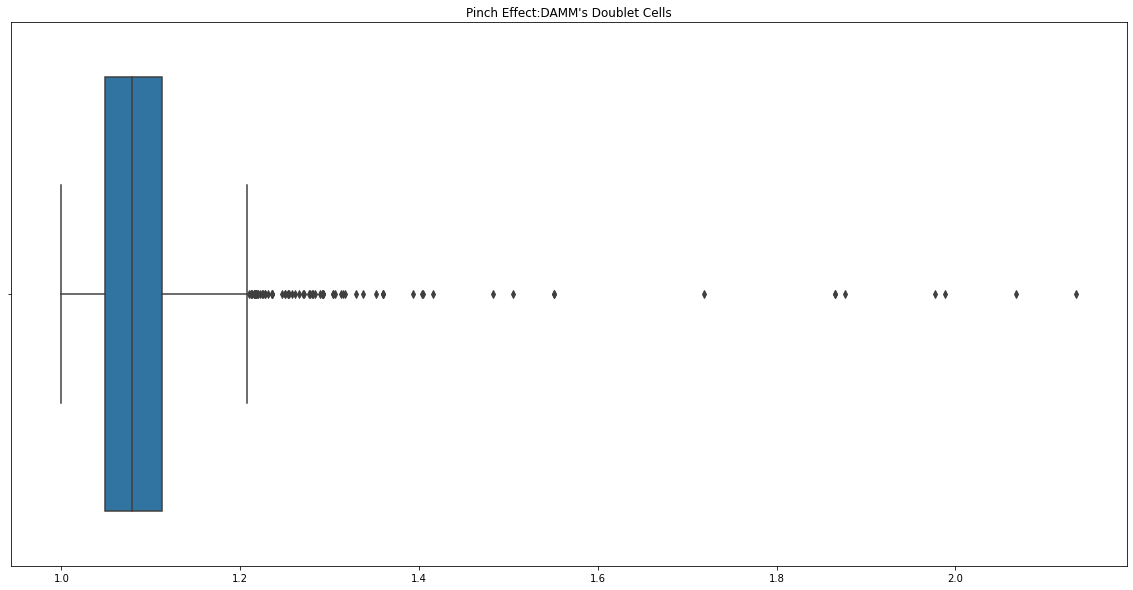

In [65]:
sns.boxplot(doublet_set['area_convex']/doublet_set['area'])
plt.title("Pinch Effect:DAMM's Doublet Cells")

# Cell sizes by cluster

<AxesSubplot:xlabel='cluster', ylabel='size'>

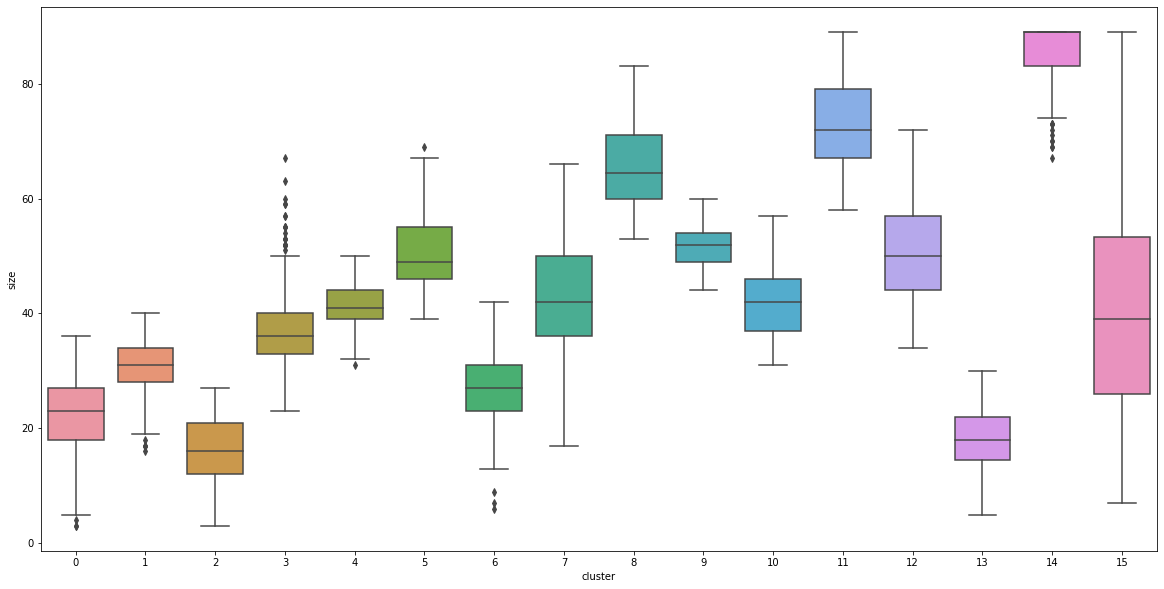

In [66]:
## phenograph
d1 = pd.DataFrame({'cluster': range(pheno_centers.shape[0]), 'psi': pheno_centers[:,-1]})
d2 = pd.DataFrame({'size': trS, 'cluster': pheno_labels})
d3 = d2.merge(d1, on='cluster')
sns.boxplot(x = 'cluster', y = 'size', data = d3)

<AxesSubplot:xlabel='cluster', ylabel='size'>

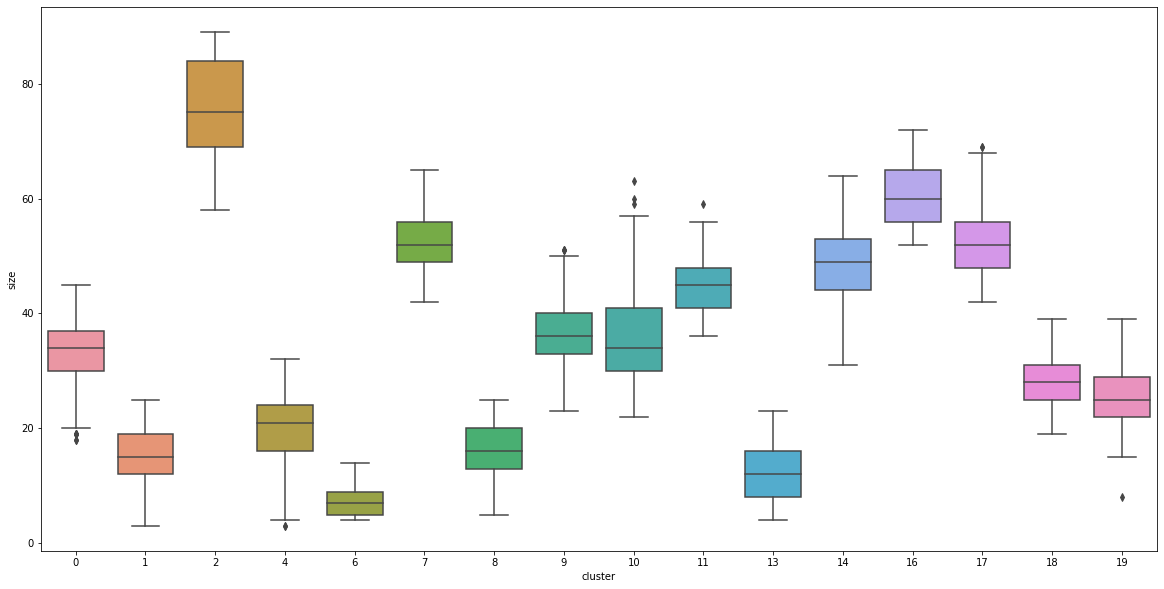

In [67]:
## FlowSOM
d1 = pd.DataFrame({'cluster': fsom_sorted_by_count, 'psi': fs_centers[:,-1]})
d2 = pd.DataFrame({'size': trS, 'cluster': fsom_labels})
d3 = d2.merge(d1, on='cluster')
sns.boxplot(x = 'cluster', y = 'size', data = d3)

<AxesSubplot:xlabel='cluster', ylabel='size'>

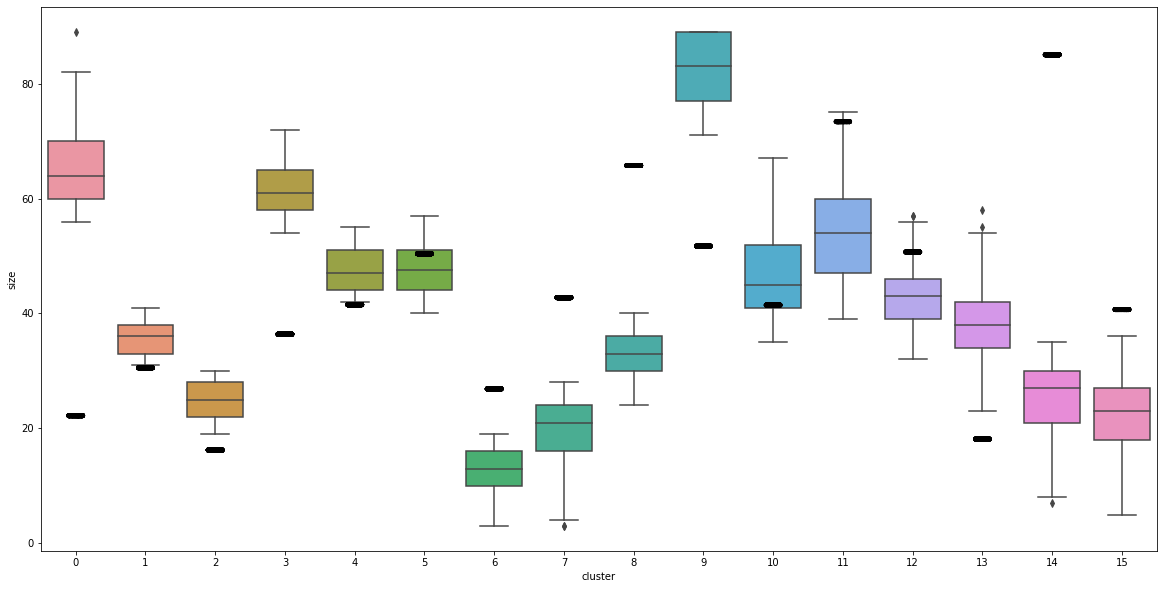

In [68]:
## kmeans
d1 = pd.DataFrame({'cluster': range(pheno_centers.shape[0]), 'psi': pheno_centers[:,-1]})
d2 = pd.DataFrame({'size': trS, 'cluster': okms_labels})
d3 = d2.merge(d1, on='cluster')

sns.stripplot(x = 'cluster', y = 'psi', data = d3, color = 'black')
sns.boxplot(x = 'cluster', y = 'size', data = d3)

<AxesSubplot:xlabel='cluster', ylabel='size'>

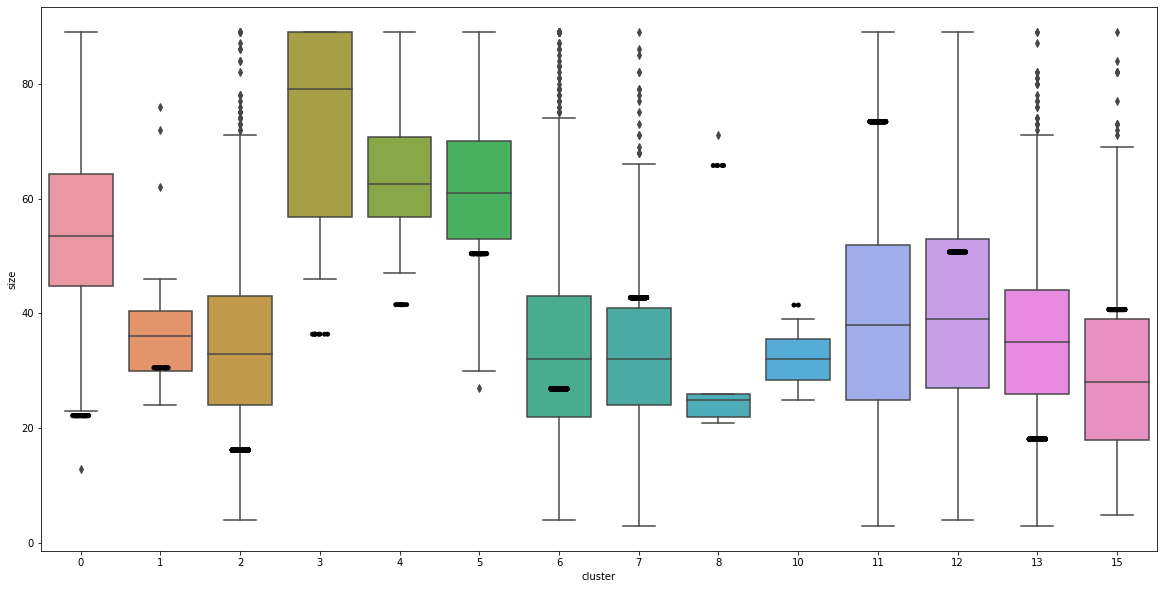

In [69]:
## damm
d1 = pd.DataFrame({'cluster': range(pheno_centers.shape[0]), 'psi': pheno_centers[:,-1]})
d2 = pd.DataFrame({'size': np.array(trS[damm_pred_singlet_label == 0]), 
                   'cluster': damm_pred_singlet_cluster_assig_label})
d3 = d2.merge(d1, on='cluster')

sns.stripplot(x = 'cluster', y = 'psi', data = d3, color = 'black')
sns.boxplot(x = 'cluster', y = 'size', data = d3)

In [70]:
'''
analysisProteins = ['B220', 'CCR7', 'CD11b', 'CD11c', 'CD19', 'CD28', 'CD3', 'CD31', 'CD4',
       'CD45', 'CD49b', 'CD68', 'CD73', 'CD8', 'CTLA4', 'DNA1', 'DNA3',
       'Epithelium', 'FOXP3', 'GATA3', 'GFP', 'GranzymeB', 'HA', 'ICOS',
       'IL7Ra', 'Ly6G', 'MHCII', 'PD1', 'PDL1', 'PNAd', 'Perforin', 'RFP',
       'S100A8-9', 'Stroma', 'TBET', 'TCF1', 'YAP', 'iNOS']

    pretty_printing = ['B220', 'CCR7', 'CD11b', 'CD11c', 'CD19', 'CD28', 'CD3', 'CD31', 'CD4',
        'CD45', 'CD49b', 'CD68', 'CD73', 'CD8', 'CTLA4', 'DNA1', 'DNA3',
        'Epithelium', 'FOXP3', 'GATA3', 'GFP', 'GranzymeB', 'HA', 'ICOS',
        'IL7Ra', 'Ly6G', 'MHCII', 'PD1', 'PDL1', 'PNAd', 'Perforin', 'RFP',
        'S100A8-9', 'Stroma', 'TBET', 'TCF1', 'YAP', 'iNOS', 'size']

    analysisProteins = ['totHH3', 'H3K27me3', 'CK5', 'Fibronectin', 'CK19',
                'CK8_18', 'Twist', 'CD68', 'CK14', 'SMA', 'Vimentin', 'cMyc', 'HER2', 'CD3', 'pHH3', 'ERK',
                'Slug', 'ER', 'PR', 'p53', 'CD44', 'EpCAM', 'CD45', 'GATA3', 'CD20', 'bCatenin', 'CAIX',
                'ECadherin', 'Ki67', 'EGFR', 'pS6', 'Sox9', 'CD31', 'mTOR', 'CK7', 'panCK', 'cPARP-cCasp3',
                'DNA1', 'DNA2']

    pretty_printing = ['totHH3', 'H3K27me3', 'CK5', 'Fibronectin', 'CK19',
                'CK8_18', 'Twist', 'CD68', 'CK14', 'SMA', 'Vimentin', 'cMyc', 'HER2', 'CD3', 'pHH3', 'ERK',
                'Slug', 'ER', 'PR', 'p53', 'CD44', 'EpCAM', 'CD45', 'GATA3', 'CD20', 'bCatenin', 'CAIX',
                'ECadherin', 'Ki67', 'EGFR', 'pS6', 'Sox9', 'CD31', 'mTOR', 'CK7', 'panCK', 'cPARP-cCasp3',
                'DNA1', 'DNA2', 'size']
    
    analysisProteins = ['TotalHH3', 'H3K27me3', 'Cytokeratin5', 'Fibronectin',
       'Cytokeratin19', 'Cytokeratin8/18', 'Twist', 'CD68', 'Keratin14', 'SMA',
       'Vimentin', 'cMyc', 'cerbB2_Her2', 'CD3', 'phospho_HH3', 'Erk1/2',
       'Slug', 'RabbitIgGHL', 'Progesterone_Receptor_A/B', 'p53', 'CD44',
       'EpCAM', 'CD45', 'GATA3', 'CD20', 'bCatenin', 'Carbonic_Anhydrase_IX',
       'Ecadherin', 'Ki67', 'EGFR', 'S6', 'Sox9', 'vWF_CD31', 'mTOR',
       'Cytokeratin7', 'panCytokeratin/Keratin_Epithelial',
       'cleavedPARP_CleavedCaspase3', 'DNA1', 'DNA2']

    pretty_printing = ['totHH3', 'H3K27me3', 'CK5', 'Fibronectin', 'CK19', 'CK8_18', 'Twist', 'CD68', 'KK14', 'SMA', 'Vimentin', 'cMyc', 
         'Her2', 'CD3', 'pHH3', 'ERK', 'Slug', 'RabbitIgGHL', 'PR', 'p53', 'CD44', 'EpCAM', 'CD45', 'GATA3',
         'CD20', 'bCatenin', 'CAIX', 'ECadherin', 'Ki67', 'EGFR', 'S6', 'Sox9', 'CD31', 'mTOR', 'CK7', 'panCK',
         'cPARP-cCasp3', 'DNA1', 'DNA2', 'size']
'''

"\nanalysisProteins = ['B220', 'CCR7', 'CD11b', 'CD11c', 'CD19', 'CD28', 'CD3', 'CD31', 'CD4',\n       'CD45', 'CD49b', 'CD68', 'CD73', 'CD8', 'CTLA4', 'DNA1', 'DNA3',\n       'Epithelium', 'FOXP3', 'GATA3', 'GFP', 'GranzymeB', 'HA', 'ICOS',\n       'IL7Ra', 'Ly6G', 'MHCII', 'PD1', 'PDL1', 'PNAd', 'Perforin', 'RFP',\n       'S100A8-9', 'Stroma', 'TBET', 'TCF1', 'YAP', 'iNOS']\n\n    pretty_printing = ['B220', 'CCR7', 'CD11b', 'CD11c', 'CD19', 'CD28', 'CD3', 'CD31', 'CD4',\n        'CD45', 'CD49b', 'CD68', 'CD73', 'CD8', 'CTLA4', 'DNA1', 'DNA3',\n        'Epithelium', 'FOXP3', 'GATA3', 'GFP', 'GranzymeB', 'HA', 'ICOS',\n        'IL7Ra', 'Ly6G', 'MHCII', 'PD1', 'PDL1', 'PNAd', 'Perforin', 'RFP',\n        'S100A8-9', 'Stroma', 'TBET', 'TCF1', 'YAP', 'iNOS', 'size']\n\n    analysisProteins = ['totHH3', 'H3K27me3', 'CK5', 'Fibronectin', 'CK19',\n                'CK8_18', 'Twist', 'CD68', 'CK14', 'SMA', 'Vimentin', 'cMyc', 'HER2', 'CD3', 'pHH3', 'ERK',\n                'Slug', 'ER', 'PR', 'p